In [1]:
## Author: Aliénor Lahlou 10/2021

## Introduction

This jupyter notebook allows you to analyse the data of a video of relaxation of Dronpa 2 (D2) under light in the XXX-XX range in order to retrieve the intensity received by the D2 sample.   
The relaxation time depends on the light intensity. Even if the intensity is unknown, a few preliminay tests will allow you to adjust the framerate.  
If the relaxation is too fast, use a density filter and correct the final intensity with the filter OD.  

User: 
- choose the best thresholding method
- enter the framerate of the video
- chose the downscaling kernel size


In [21]:
from app_dash import *


save_folder = "../images/"
extension= ".pdf"


#%matplotlib widget

### sequence of images:

In [45]:
ref = 6
video = []
folder = '../data/fps2_blue5_60pm_1over2led_expo400ms_petri35mm'
for im in glob.glob(folder + "/*.tif"):
    video.append(tiff.imread(im))
video = np.array(video)
video.shape

(168, 2048, 2048)

### video file

In [63]:
file = glob.glob("../data/video_light.tiff")[0]

video = tiff.imread(file)
video.shape
#tiff.imwrite("video_light.tiff", video[0:25])

(25, 608, 968)

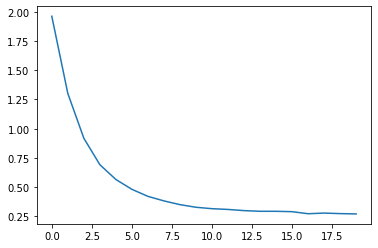

In [64]:
plt.plot(np.mean(video[4:-1], axis = (1,2)))

### select first frame and last frames

(-0.5, 967.5, 607.5, -0.5)

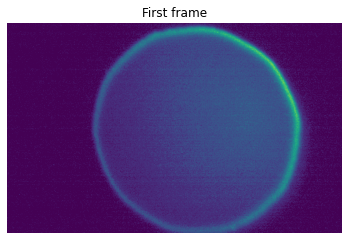

In [70]:
start = 0 #<-------- modify here enter number of the first frame not in the dark
stop = 60
plt.title("First frame")
plt.imshow(video[ref])
plt.axis("off")


### try masks

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


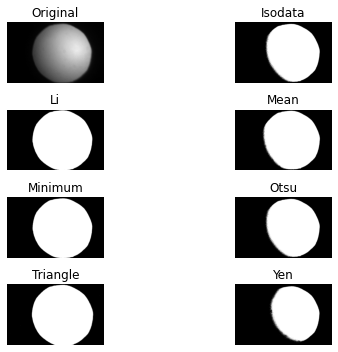

In [71]:
u = skimage.filters.try_all_threshold(video[start])

### Downscaling

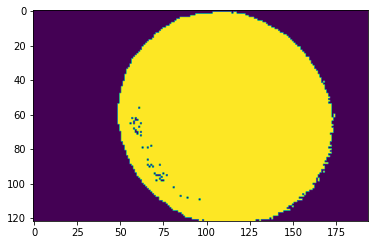

In [72]:
D = 5 #<---------- smoothing & downscaling kernel to accelerate computations
video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video)) #generate time array from framerate
mask = downscale_local_mean(video[ref], (D,D))
threshold = skimage.filters.threshold_minimum(mask) #<----- replace here for the correct thresholding value, the computations will only be performed where pixel_value>threshold
#select it from the image that best matches a mask, and copy the corresponding function name printed above

mask = mask>threshold
plt.imshow(mask)


#downscaling 
video_downscaled = []
for i in range(video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

### Fit on the mean of all the unmasked points
It is normal if the fit doesn't appear monoexponential here: it is expected to be multi-exponential if the distribution of intensities is wide-spread

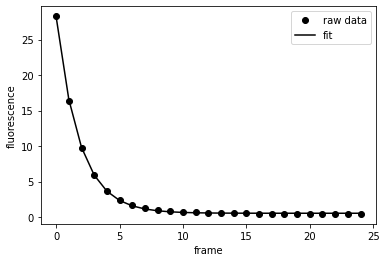

In [73]:
#fit on the mean value before performing the fit on each pixel
params = simple_tau(np.mean(to_evaluate[start:stop], axis = 1), timing[start:stop], sample_rate = 1)


time = timing[start:stop]
plt.plot(time, np.mean(to_evaluate[start:stop], axis = 1), "ok", label = "raw data")
plt.plot(time, exp_decay(params, time), "k", label = "fit")
plt.xlabel('frame')
plt.ylabel("fluorescence")
plt.legend()
plt.savefig(save_folder + "mean_decay_fit_D2.png")

### Check no saturation

In [74]:
sat = np.sum(to_evaluate[0:10]==255)/len(to_evaluate[0:10].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


### Run the fits in parallel

In [75]:
#parallel fit on each ixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = 1) for i in tqdm(range(to_evaluate.shape[1])))
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480

100%|██████████████████████████████████████████████████████████████████████████| 11900/11900 [00:02<00:00, 4145.42it/s]


## Results overview

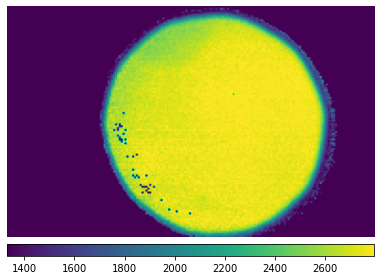

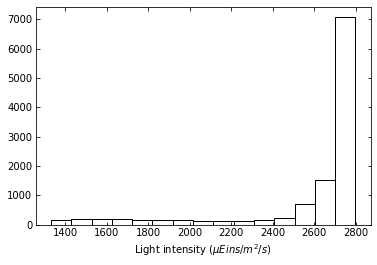

In [76]:
I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_init = np.copy(I_480)
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480
plt.rcParams['image.cmap'] = 'viridis'


 
I, dis = plot_map(I_480, I_480_map,"test_app" + "_I_480_map_B" + extension, save_folder)



## Results

In [78]:
JupyterDash.infer_jupyter_proxy_config()

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Create server variable with Flask server object for use with gunicorn
server = app.server


layout = html.Div([
        html.Div([            
            html.Label("Framerate"),
            dcc.Input(value= 3, type='number', id="framerate"),
            
            html.Label("Lower limit"),
            dcc.Input(value= int(np.quantile(I_480, 0.01)), type='number', id="Q1"),
            
                        
            html.Label("Upper limit"),
            dcc.Input(value= int(np.quantile(I_480, 0.9999)), type='number', id="Q3"),
            
            dcc.RadioItems(id='logchoice', options = ['linear', 'log'], value = 'linear'),
            dcc.Store(id='I_map'),
            html.Br()
            
        ], style={'display': 'flex', "flex-direction":"row", 'width':'100%'}
        ),   

        html.Div([

            dcc.Graph(id="distribution", figure = fig_init),
            dcc.Graph(id="trace", figure = fig_init),

        ],
        style={'width': '49%', 'display': 'flex'}),
]
)


app.layout = layout


@app.callback(
    Output('distribution', 'figure'),
    [Input('framerate', 'value'),
    Input('Q1', 'value'),
    Input('Q3', 'value')])
def update_distribution(framerate, Q1, Q3):
    tau_map = tau_480_map/framerate
    I = 1e6*(1/tau_map - tau_relax)/sigma_480
    I_map = np.zeros(mask.shape)

    I_map[mask] = I[mask]
    
    I_map[I_map <= Q1 ] = Q1
    I_map[I_map >= Q3 ] = Q3
    return create_distribution(I_map)


@app.callback(
    Output('trace', 'figure'),
    [Input('distribution', 'hoverData'),
    Input('framerate', 'value'),
    Input("logchoice", "value")])
def update_trace(hoverData, framerate, logchoice):
    if logchoice=="log":
        log=True
    else:
        log=False
        
    x = hoverData['points'][0]["x"]
    y = hoverData['points'][0]["y"]
    trace = video_2D[start:stop, y,x]
    time = np.linspace(0, len(trace)-1, len(trace))
    return create_trace(time, trace, framerate, log)

app.run_server(mode="inline")


C:\Users\Alienor\AppData\Local\Temp\ipykernel_13476\1585111120.py:49: RuntimeWarning:

divide by zero encountered in true_divide



---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
TypeError: 'NoneType' object is not subscriptable



G:\DREAM\from_github\light_calibration\notebooks\app_dash.py:54: RuntimeWarning:

overflow encountered in exp



---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
TypeError: '>=' not supported between instances of 'float' and 'NoneType'

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
TypeError: '<=' not supported between instances of 'float' and 'NoneType'

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
TypeError: '<=' not supported between instances of 'float' and 'NoneType'



### Debuging: print the fits
**Warning !** re-run the code above and use a high value for the downscaling parameter D in order to minimise the number of plots. 

In [ ]:
#Uncomment to debug. 
#for i in tqdm(range(to_evaluate.shape[1])):
#    simple_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) 


C:\Users\Alienor\anaconda3\envs\tf-gpu\lib\site-packages\jupyter_dash\comms.py:100: RuntimeWarning:

coroutine 'Kernel.execute_request' was never awaited

